# MonReader
- Author: Yumo Bai
- Email: baiym104@gmail.com
- Date: Apr 10

## Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

## Build Data Pipeline

In [2]:
import os
import zipfile

local_zip = './images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('.')
zip_ref.close()

The data are stored in the zip file which contains training and testing directories of flip and not flipping images. Let's define the subdirectories for constructing the data pipeline later.

In [3]:
train_flip_dir = os.path.join('./images/training/flip')
train_notflip_dir = os.path.join('./images/training/notflip')
test_flip_dir = os.path.join('./images/testing/flip')
test_notflip_dir = os.path.join('./images/testing/notflip')

Now let's take a look at the size of each dataset and the sample file names.

In [4]:
dirs = [train_flip_dir, train_notflip_dir, test_flip_dir, test_notflip_dir]

for dir in dirs:
  path = dir.split('/')
  print(f'Total {path[-2]} {path[-1]} images: {len(os.listdir(dir))}')
  print(f'Sample file names: \n {os.listdir(dir)[:10]}')
  print()

Total training flip images: 1162
Sample file names: 
 ['0013_000000025.jpg', '0006_000000018.jpg', '0040_000000029.jpg', '0054_000000029.jpg', '0036_000000013.jpg', '0024_000000025.jpg', '0007_000000023.jpg', '0053_000000006.jpg', '0065_000000020.jpg', '0058_000000001.jpg']

Total training notflip images: 1230
Sample file names: 
 ['0048_000000011.jpg', '0028_000000019.jpg', '0010_000000021.jpg', '0006_000000018.jpg', '0040_000000029.jpg', '0054_000000029.jpg', '0052_000000005.jpg', '0036_000000013.jpg', '0031_000000028.jpg', '0055_000000024.jpg']

Total testing flip images: 290
Sample file names: 
 ['0048_000000011.jpg', '0028_000000019.jpg', '0010_000000021.jpg', '0031_000000028.jpg', '0055_000000024.jpg', '0006_000000012.jpg', '0026_000000010.jpg', '0037_000000008.jpg', '0058_000000019.jpg', '0051_000000021.jpg']

Total testing notflip images: 307
Sample file names: 
 ['0024_000000025.jpg', '0002_000000006.jpg', '0001_000000004.jpg', '0019_000000002.jpg', '0026_000000010.jpg', '0029

Now we can take a look at how do the pictures look like. 

In [5]:
# Parameters for our graph, we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

train_flip_img_names = os.listdir(train_flip_dir)
train_notflip_img_names = os.listdir(train_notflip_dir)

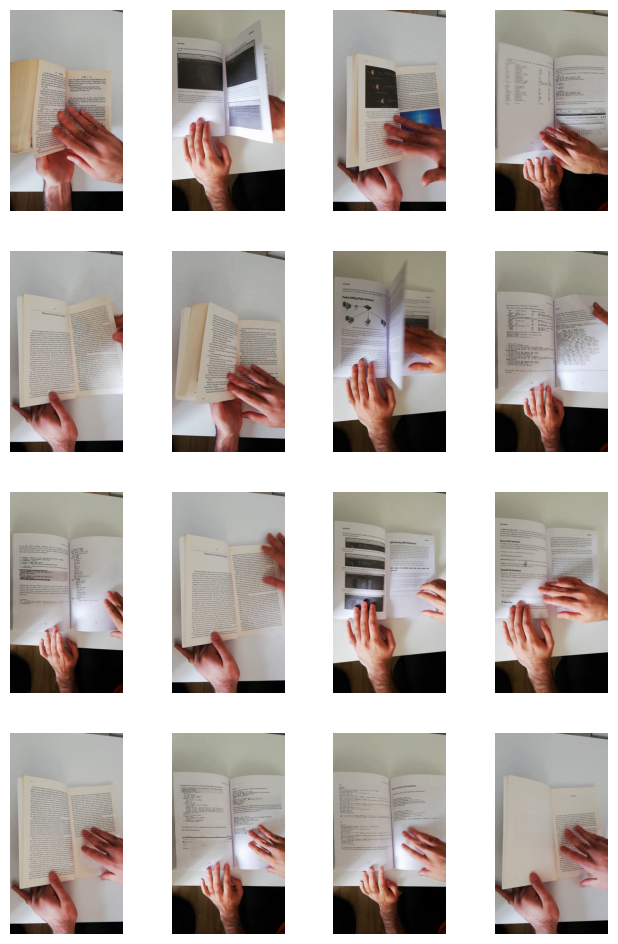

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 2, nrows * 3)

pic_index += 8
next_flip_pic = [os.path.join(train_flip_dir, fname) 
                for fname in train_flip_img_names[pic_index-8:pic_index]]
next_notflip_pic = [os.path.join(train_notflip_dir, fname) 
                for fname in train_notflip_img_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_flip_pic + next_notflip_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Now, let's use keras.preprocessing.image.ImageDataGenerator class to create our train and test dataset and normalize our data.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled and augmented to avoid overfitting
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255.,
                                  rotation_range=10,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  fill_mode='nearest')

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './images/training',  # This is the source directory for training images
        classes = ['flip', 'notflip'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=120,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
test_generator = test_datagen.flow_from_directory(
        './images/testing',  # This is the source directory for training images
        classes = ['flip', 'notflip'],
        target_size=(200, 200),  # All images will be resized to 200x200
        batch_size=20,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


## Building CNN model

In [8]:
def create_model():
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.binary_crossentropy,
                metrics=['accuracy']) 

  return model

### Verify TPU connection

In [9]:
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [10]:
# with tpu_strategy.scope():
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0

In [11]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=test_generator)

Epoch 1/15
20/20 [==============================] - 341s 17s/step - loss: 0.7819 - accuracy: 0.5100 - val_loss: 0.6883 - val_accuracy: 0.5142
Epoch 2/15
20/20 [==============================] - 356s 18s/step - loss: 0.6806 - accuracy: 0.5640 - val_loss: 0.6778 - val_accuracy: 0.5729
Epoch 3/15
20/20 [==============================] - 343s 17s/step - loss: 0.6322 - accuracy: 0.6534 - val_loss: 0.6447 - val_accuracy: 0.5796
Epoch 4/15
20/20 [==============================] - 347s 17s/step - loss: 0.5641 - accuracy: 0.7182 - val_loss: 0.5966 - val_accuracy: 0.7069
Epoch 5/15
20/20 [==============================] - 373s 19s/step - loss: 0.5454 - accuracy: 0.7111 - val_loss: 0.5794 - val_accuracy: 0.7018
Epoch 6/15
20/20 [==============================] - 333s 16s/step - loss: 0.4915 - accuracy: 0.7684 - val_loss: 0.6481 - val_accuracy: 0.6566
Epoch 7/15
20/20 [==============================] - 331s 16s/step - loss: 0.4478 - accuracy: 0.7914 - val_loss: 0.6021 - val_accuracy: 0.7538
Epoch 

Now let's save the model.

In [13]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
model.save('my_model.h5')

### Model Evaluation

In [16]:
model.evaluate(test_generator)

30/30 [==============================] - 34s 1s/step - loss: 0.4168 - accuracy: 0.8409


[0.416794091463089, 0.8408710360527039]

The model has 84% accuracy on the test set, which is lower than the 92% on the training set. This indicates that the model is still overfitting the training data and we could consider using a simpler model or increase the strength of data augmentation when building the data pipeline.

Now let's plot the roc_auc curve of the model and see how it performs.

In [17]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
preds = model.predict(test_generator,
                      verbose=1)

30/30 [==============================] - 39s 1s/step


In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_generator.classes, preds)
roc_auc = auc(fpr, tpr)

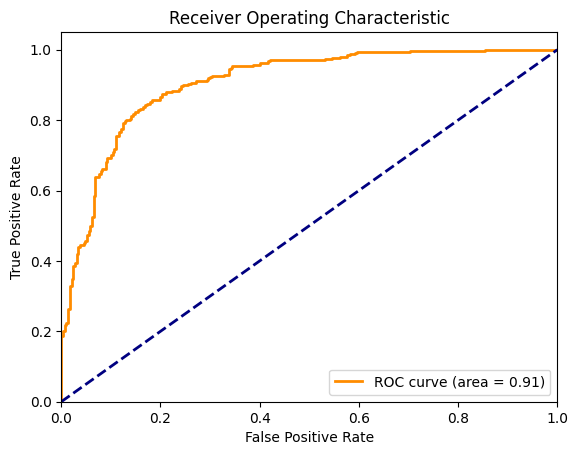

In [19]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The model appears to be performing well with auc of 0.91. 